In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import scanpy as sc
import numpy as np

import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score, matthews_corrcoef, cohen_kappa_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [3]:
base_dir = Path().resolve()
parent_dir = base_dir.parent
parent_dir

PosixPath('/home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling')

## Read flux and TMA preprocessed Data

### Read Metabolic Task data

In [4]:
metabolic_task_df = pd.read_csv(parent_dir / 'data/scCellFie/scCellFie_metabolic_tasks_with_name.csv', low_memory=False)
metabolic_task_df.rename(columns={'Unnamed: 0':'cell'},inplace=True)
metabolic_task_df.head()

,cell,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,...,Tyrosine to adrenaline,Tyrosine to dopamine,Uridine triphosphate synthesis (UTP),Valine degradation,Vesicle secretion,beta-Alanine degradation,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation
0,58_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,191_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,193_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print("count of +inf:", np.isposinf(metabolic_task_df.iloc[:,1:].to_numpy()).sum())
print("count of -inf:", np.isneginf(metabolic_task_df.iloc[:,1:].to_numpy()).sum())

count of +inf: 0
count of -inf: 10


In [6]:
metabolic_task_df = metabolic_task_df.replace(-np.inf, 0)

### Read Reactions data

In [7]:
reactions_df = pd.read_csv(parent_dir / 'data/scCellFie/scCellFie_reactions_with_name.csv', low_memory=False)
reactions_df.rename(columns={'Unnamed: 0':'cell'},inplace=True)
reactions_df.head()

,cell,3HLYTCL,5HLTDL,ACCOAC,ACCOACm,AG13T10g,AG13T11g,AG13T12g,AG13T13g,AG13T14g,...,co_TRANSLOC_6,co_TRANSLOC_7,post_TRANSLOC_1,post_TRANSLOC_2,post_TRANSLOC_3B_1,post_TRANSLOC_3B_2,post_TRANSLOC_3B_3,r0173,r0773,retro_TRANSLOC_1
0,58_1_TMA1_minimal,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.676326,NaN,0.0
1,63_1_TMA1_minimal,NaN,NaN,0.0,-35.179247,0.134017,0.134017,0.134017,0.134017,0.134017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477122,NaN,0.0
2,87_1_TMA1_minimal,2.126593,2.126593,0.0,9.054779,0.643387,0.643387,0.643387,0.643387,0.643387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.473437,0.904772,0.0
3,191_1_TMA1_minimal,NaN,NaN,0.0,8.378964,0.655214,0.655214,0.655214,0.655214,0.655214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.108381,0.762824,0.0
4,193_1_TMA1_minimal,NaN,NaN,0.0,-4.701980,0.682674,0.682674,0.682674,0.682674,0.682674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.128436,1.038290,0.0


In [8]:
print("count of +inf:", np.isposinf(reactions_df.iloc[:,1:].to_numpy()).sum())
print("count of -inf:", np.isneginf(reactions_df.iloc[:,1:].to_numpy()).sum())

count of +inf: 0
count of -inf: 317086


In [9]:
reactions_df = reactions_df.replace(-np.inf, 0)

### Read selected gene expression data

In [10]:
gene_df = pd.read_csv(parent_dir / 'data/scCellFie/scCellFie_genes_with_name.csv', low_memory=False)
gene_df.rename(columns={'Unnamed: 0':'cell'},inplace=True)
gene_df.head()

,cell,ACACB,ARF1,ARG1,ATP5F1E,B3GNT7,CALM1,CYP1B1,CYP2U1,DDC,...,HSP90B1,IDO1,KYNU,LDHA,PTGS1,PTGS2,SEC61G,ST6GAL1,TP53,TYMS
0,58_1_TMA1_minimal,-5.138619,8.119103,2.836610,2.492469,-4.380625,20.516544,-4.738219,-4.377451,-6.284169,...,14.687612,-4.471430,-5.358273,6.147044,-4.321997,-3.065980,-15.751696,-6.612187,12.668953,-9.150918
1,63_1_TMA1_minimal,-3.541723,4.561964,-2.779527,-2.243974,1.560384,6.831265,-4.168286,29.780418,-7.596944,...,-1.012455,19.031523,-2.789910,1.174960,-3.802129,-3.929844,-14.178326,-5.273250,-10.162521,-6.501061
2,87_1_TMA1_minimal,18.136440,4.033157,-2.392830,0.948675,22.993375,-8.208050,-3.588381,-3.315162,15.884180,...,-13.579868,-4.490324,-4.057965,5.036203,25.181430,-0.897421,-8.557185,11.860245,-6.510208,5.960089
3,191_1_TMA1_minimal,15.395354,8.423884,-2.329424,0.719245,24.102954,9.592794,-3.493294,-0.936705,-3.568302,...,4.421024,-4.371337,-3.950435,9.015220,-3.186431,-1.705948,5.554974,12.468108,9.490307,-5.532738
4,193_1_TMA1_minimal,-2.160676,8.438063,-2.875661,5.004335,26.868916,7.875155,-2.479085,0.351055,-5.432313,...,-16.605717,-3.960222,-3.554977,9.167266,-3.933632,-4.065764,-12.952505,-6.067353,-9.663771,9.325951


In [11]:
print("count of +inf:", np.isposinf(gene_df.iloc[:,1:].to_numpy()).sum())
print("count of -inf:", np.isneginf(gene_df.iloc[:,1:].to_numpy()).sum())

count of +inf: 0
count of -inf: 0


### Read adata data

In [12]:
adata = sc.read(parent_dir / 'data/h5ad/merged_TMA_processed_compatible_n_gene_200.h5ad')
adata

AnnData object with n_obs × n_vars = 242061 × 1011
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'leiden'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [13]:
# Extract UMAP
umap_df = pd.DataFrame(
    adata.obsm['X_umap'],
    index=adata.obs.index,
    columns=['UMAP1', 'UMAP2']
)

# Extract spatial
spatial_df = pd.DataFrame(
    adata.obsm['spatial'],
    index=adata.obs.index,
    columns=['X_spatial', 'Y_spatial']
)

# Concatenate along columns
coords_df = pd.concat([umap_df, spatial_df], axis=1)
coords_df = coords_df.reset_index().rename(columns={"index": "cell"})
coords_df

,cell,UMAP1,UMAP2,X_spatial,Y_spatial
0,58_1_TMA1_minimal,14.224506,-2.921017,-429682.636002,76823.002454
1,63_1_TMA1_minimal,14.220473,-2.735177,-429536.814032,76796.188060
2,87_1_TMA1_minimal,13.975760,-2.981336,-430293.785879,76689.999997
3,191_1_TMA1_minimal,13.998773,-3.013293,-430401.639032,76349.163060
4,193_1_TMA1_minimal,13.981592,-3.005577,-430146.237883,76368.695244
...,...,...,...,...,...
242056,398_417_TMA4_minimal,12.367579,-2.590616,-116721.115763,-59256.030353
242057,405_417_TMA4_minimal,12.308885,-2.760632,-116965.982523,-59255.507211
242058,411_417_TMA4_minimal,12.499968,-2.856575,-116917.852088,-59298.159385
242059,418_417_TMA4_minimal,12.512590,-2.751443,-116801.850018,-59277.445099


In [14]:
cols = ["sample", "leiden","cell_type", "Treatment_Status", "Subject_ID" ]
obs_df = adata.obs[cols].copy()
obs_df = adata.obs[cols].reset_index().rename(columns={"index": "cell"})
obs_df

,cell,sample,leiden,cell_type,Treatment_Status,Subject_ID
0,58_1_TMA1_minimal,TMA1_minimal,16,TA,Treated,89397
1,63_1_TMA1_minimal,TMA1_minimal,16,TA,Treated,89397
2,87_1_TMA1_minimal,TMA1_minimal,16,TA,Treated,89397
3,191_1_TMA1_minimal,TMA1_minimal,16,a,Treated,89397
4,193_1_TMA1_minimal,TMA1_minimal,16,TA,Treated,89397
...,...,...,...,...,...,...
242056,398_417_TMA4_minimal,TMA4_minimal,16,Colonocyte,Untreated,1228762B
242057,405_417_TMA4_minimal,TMA4_minimal,16,Colonocyte,Untreated,1228762B
242058,411_417_TMA4_minimal,TMA4_minimal,16,Colonocyte,Untreated,1228762B
242059,418_417_TMA4_minimal,TMA4_minimal,16,Colonocyte,Untreated,1228762B


In [15]:
obs_coords_df = obs_df.merge(coords_df, on="cell", how="inner")
obs_coords_df

,cell,sample,leiden,cell_type,Treatment_Status,Subject_ID,UMAP1,UMAP2,X_spatial,Y_spatial
0,58_1_TMA1_minimal,TMA1_minimal,16,TA,Treated,89397,14.224506,-2.921017,-429682.636002,76823.002454
1,63_1_TMA1_minimal,TMA1_minimal,16,TA,Treated,89397,14.220473,-2.735177,-429536.814032,76796.188060
2,87_1_TMA1_minimal,TMA1_minimal,16,TA,Treated,89397,13.975760,-2.981336,-430293.785879,76689.999997
3,191_1_TMA1_minimal,TMA1_minimal,16,a,Treated,89397,13.998773,-3.013293,-430401.639032,76349.163060
4,193_1_TMA1_minimal,TMA1_minimal,16,TA,Treated,89397,13.981592,-3.005577,-430146.237883,76368.695244
...,...,...,...,...,...,...,...,...,...,...
242056,398_417_TMA4_minimal,TMA4_minimal,16,Colonocyte,Untreated,1228762B,12.367579,-2.590616,-116721.115763,-59256.030353
242057,405_417_TMA4_minimal,TMA4_minimal,16,Colonocyte,Untreated,1228762B,12.308885,-2.760632,-116965.982523,-59255.507211
242058,411_417_TMA4_minimal,TMA4_minimal,16,Colonocyte,Untreated,1228762B,12.499968,-2.856575,-116917.852088,-59298.159385
242059,418_417_TMA4_minimal,TMA4_minimal,16,Colonocyte,Untreated,1228762B,12.512590,-2.751443,-116801.850018,-59277.445099


### Merge datasets

In [16]:
dataset = metabolic_task_df.merge(obs_coords_df, on="cell", how="inner") \
               .merge(reactions_df, on="cell", how="inner") \
               .merge(gene_df, on="cell", how="inner")

# dataset = gene_df.merge(obs_coords_df, on="cell", how="inner") \
#                .merge(reactions_df, on="cell", how="inner")

# dataset = metabolic_task_df.merge(obs_coords_df, on="cell", how="inner")
# dataset

dataset["treatment_encoded"] = dataset["Treatment_Status"].map({"Untreated": 0, "Treated": 1})
dataset

,cell,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,...,IDO1,KYNU,LDHA,PTGS1,PTGS2,SEC61G,ST6GAL1,TP53,TYMS,treatment_encoded
0,58_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.471430,-5.358273,6.147044,-4.321997,-3.065980,-15.751696,-6.612187,12.668953,-9.150918,1
1,63_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.031523,-2.789910,1.174960,-3.802129,-3.929844,-14.178326,-5.273250,-10.162521,-6.501061,1
2,87_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.490324,-4.057965,5.036203,25.181430,-0.897421,-8.557185,11.860245,-6.510208,5.960089,1
3,191_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.371337,-3.950435,9.015220,-3.186431,-1.705948,5.554974,12.468108,9.490307,-5.532738,1
4,193_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.960222,-3.554977,9.167266,-3.933632,-4.065764,-12.952505,-6.067353,-9.663771,9.325951,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242056,398_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.098676,-1.610100,-1.166847,-2.711357,-2.802432,-9.983576,-5.560806,-6.968706,-6.486689,0
242057,405_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.260107,-3.849914,6.176809,-3.105351,-1.639232,-9.437174,-6.368860,-9.043190,-7.293438,0
242058,411_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.367172,-3.137285,-0.904928,-1.798173,-3.757652,-10.584222,-7.456227,-9.948525,-8.760313,0
242059,418_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.884938,25.163876,-3.400420,-2.873141,-2.969651,6.210321,-5.405629,4.599068,-7.012637,0


### Distribution of Cell count and status per Subject ID

In [17]:
status_counts = dataset.groupby(["Subject_ID", "Treatment_Status"]).size().unstack(fill_value=0)
status_counts

Treatment_Status,Treated,Untreated
Subject_ID,,
78410A1,0,3192
89397,7644,0
92604,13137,0
95278A2,0,1024
114262,12,0
118223A,0,11317
120136,9535,0
120139,0,13716
120140,0,3630


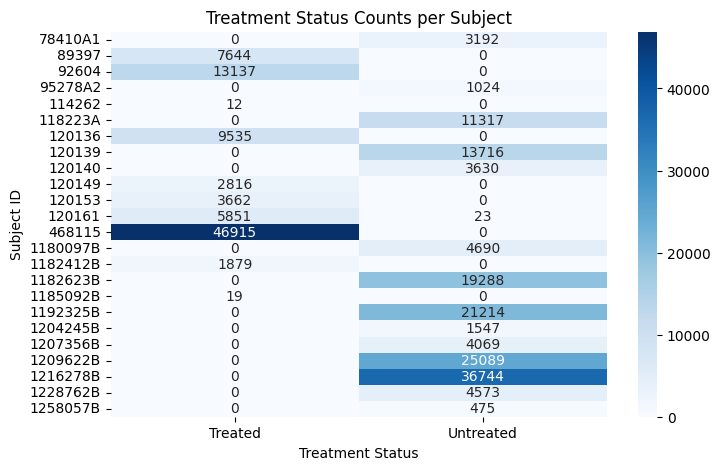

In [18]:
plt.figure(figsize=(8,5))
sns.heatmap(status_counts, annot=True, cmap="Blues", fmt="d")
plt.title("Treatment Status Counts per Subject")
plt.ylabel("Subject ID")
plt.xlabel("Treatment Status")
plt.show()


In [19]:
cell_counts = dataset.groupby("Subject_ID")["cell"].nunique()
cell_counts

Subject_ID
78410A1      3192
89397        7644
92604       13137
95278A2      1024
114262         12
118223A     11317
120136       9535
120139      13716
120140       3630
120149       2816
120153       3662
120161       5874
468115      46915
1180097B     4690
1182412B     1879
1182623B    19288
1185092B       19
1192325B    21214
1204245B     1547
1207356B     4069
1209622B    25089
1216278B    36744
1228762B     4573
1258057B      475
Name: cell, dtype: int64

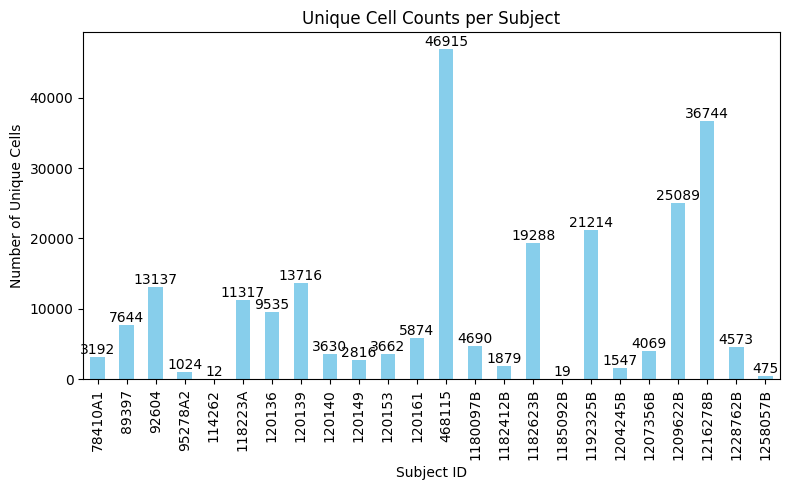

In [20]:
ax = cell_counts.plot(kind="bar", figsize=(8,5), color="skyblue")

# Add value labels
for container in ax.containers:
    ax.bar_label(container)
    
plt.title("Unique Cell Counts per Subject")
plt.xlabel("Subject ID")
plt.ylabel("Number of Unique Cells")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
print(status_counts.index)
print(cell_counts.index)

CategoricalIndex(['78410A1', '89397', '92604', '95278A2', '114262', '118223A',
                  '120136', '120139', '120140', '120149', '120153', '120161',
                  '468115', '1180097B', '1182412B', '1182623B', '1185092B',
                  '1192325B', '1204245B', '1207356B', '1209622B', '1216278B',
                  '1228762B', '1258057B'],
                 categories=['78410A1', '89397', '92604', '95278A2', ..., '1209622B', '1216278B', '1228762B', '1258057B'], ordered=False, dtype='category', name='Subject_ID')
CategoricalIndex(['78410A1', '89397', '92604', '95278A2', '114262', '118223A',
                  '120136', '120139', '120140', '120149', '120153', '120161',
                  '468115', '1180097B', '1182412B', '1182623B', '1185092B',
                  '1192325B', '1204245B', '1207356B', '1209622B', '1216278B',
                  '1228762B', '1258057B'],
                 categories=['78410A1', '89397', '92604', '95278A2', ..., '1209622B', '1216278B', '1228762B', '125805

In [31]:
# summary = status_counts.join(cell_counts.rename("num_cells").to_frame())
# summary
summary = pd.concat(
    [status_counts, cell_counts.rename("num_cells")],
    axis=1
)


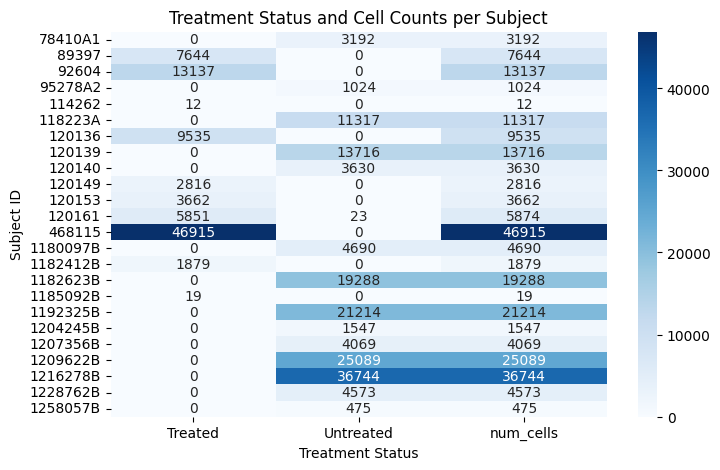

In [32]:
plt.figure(figsize=(8,5))
sns.heatmap(summary, annot=True, cmap="Blues", fmt="d")
plt.title("Treatment Status and Cell Counts per Subject")
plt.ylabel("Subject ID")
plt.xlabel("Treatment Status")
plt.show()

### Class Balance Analysis

In [33]:
dataset["Treatment_Status"].value_counts()

Treatment_Status
Untreated    150591
Treated       91470
Name: count, dtype: int64

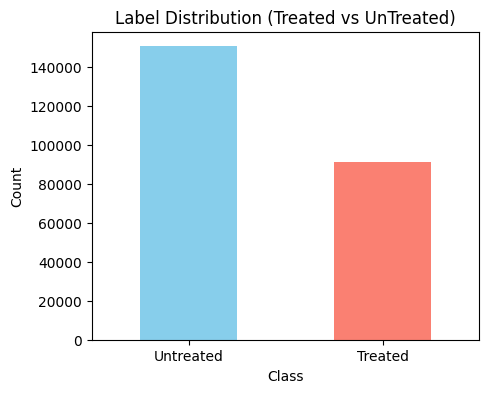

In [34]:
plt.figure(figsize=(5,4))
dataset["Treatment_Status"].value_counts().plot(
    kind="bar",
    color=["skyblue", "salmon"]
)
plt.title("Label Distribution (Treated vs UnTreated)")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.show()

# Classification Problem (Treated vs Untreated Cells)

## Cell Based Classification

### Dataset Definition

In [35]:
dataset = pd.get_dummies(dataset, columns=["cell_type"])
dataset

,cell,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,...,cell_type_Tuft,cell_type_a,cell_type_arterial.capillary,cell_type_b,cell_type_c,cell_type_cDC,cell_type_d,cell_type_myofibroblast,cell_type_pDC,cell_type_venous.capillary
0,58_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,63_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,87_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,191_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False
4,193_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242056,398_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
242057,405_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
242058,411_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
242059,418_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [36]:
#"Treatment_Status","Subject_ID","treatment_encoded","sample","cell","leiden","X_spatial","Y_spatial","UMAP1","UMAP2","cell_type
X = dataset.drop(columns=["Treatment_Status","Subject_ID","treatment_encoded","sample","cell","X_spatial","Y_spatial"])
y = dataset["treatment_encoded"]
feature_names = X.columns.tolist()

In [37]:
patients = dataset["Subject_ID"].unique()

train_patients, test_patients = train_test_split(
    patients,
    test_size=0.2,
    random_state=42,
    stratify=dataset.groupby("Subject_ID")["Treatment_Status"].first() 
)

In [38]:
X_train = X[dataset["Subject_ID"].isin(train_patients)]
y_train = y[dataset["Subject_ID"].isin(train_patients)]

X_test = X[dataset["Subject_ID"].isin(test_patients)]
y_test = y[dataset["Subject_ID"].isin(test_patients)]

### Feature Scaling

In [39]:
# Standardization Dataset
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

### Model Training

In [40]:
# Train Randomforest Classifier
rf = RandomForestClassifier(
   n_estimators=300, 
   random_state=42, 
   max_depth=8, 
   min_samples_split=20, 
   min_samples_leaf=10,
   class_weight="balanced",
   n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

train_acc = rf.score(X_train_scaled, y_train)
test_acc = rf.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")


Train Accuracy: 0.914, Test Accuracy: 0.827


In [41]:
# Trian LightGBM Classifier
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

clf = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=-1,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

train_acc = clf.score(X_train_scaled, y_train)
test_acc = clf.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 81935, number of negative: 99195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50099
[LightGBM] [Info] Number of data points in the train set: 181130, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452355 -> initscore=-0.191161
[LightGBM] [Info] Start training from score -0.191161
Train Accuracy: 0.966, Test Accuracy: 0.728


### Evaluation

              precision    recall  f1-score   support

           0       1.00      0.68      0.81     51396
           1       0.36      0.98      0.53      9535

    accuracy                           0.73     60931
   macro avg       0.68      0.83      0.67     60931
weighted avg       0.90      0.73      0.76     60931

Confusion Matrix:
 [[34965 16431]
 [  156  9379]]


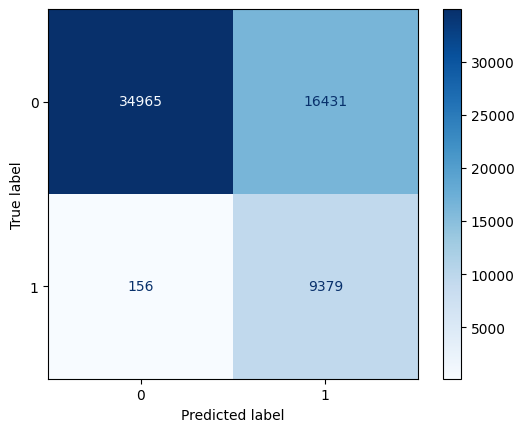

Balanced Accuracy: 0.8319725421450715


In [42]:
print(classification_report(y_pred=y_pred, y_true=y_test))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

In [43]:
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(f"PR-AUC (Average Precision): {average_precision_score(y_test, y_pred):.3f}")
print(f"Matthews Correlation Coefficient (MCC): {matthews_corrcoef(y_test, y_pred):.3f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test, y_pred):.3f}")

ROC-AUC: 0.832
PR-AUC (Average Precision): 0.360
Matthews Correlation Coefficient (MCC): 0.488
Cohen’s Kappa: 0.392


## Patient Based Classification

### Dataset Defintion

In [ ]:
dataset = pd.get_dummies(dataset, columns=["cell_type"])
dataset.set_index('cell',inplace=True)
dataset

In [ ]:
df_subjects = adata.obs.groupby("Subject_ID")["Treatment_Status"].first().reset_index()

train_subj, test_subj = train_test_split(df_subjects,test_size=0.2,random_state=42,stratify=df_subjects["Treatment_Status"])

print("Train subjects:", train_subj["Treatment_Status"].value_counts().to_dict())
print("Test subjects:", test_subj["Treatment_Status"].value_counts().to_dict())

train_idx = adata.obs.index[adata.obs["Subject_ID"].isin(train_subj["Subject_ID"])]
test_idx = adata.obs.index[adata.obs["Subject_ID"].isin(test_subj["Subject_ID"])]

print("Train cells:", adata.obs.loc[train_idx, "Treatment_Status"].value_counts().to_dict())
print("Test cells:", adata.obs.loc[test_idx, "Treatment_Status"].value_counts().to_dict())

In [ ]:
y_train, y_test = dataset["treatment_encoded"].loc[train_idx], dataset["treatment_encoded"].loc[test_idx]
dataset.drop(columns=["Treatment_Status","Subject_ID","treatment_encoded","sample"], inplace=True)
X_train, X_test = dataset.loc[train_idx], dataset.loc[test_idx]
feature_names=X_train.columns.tolist()
print("Train subjects:", train_subj.shape[0], "Test subjects:", test_subj.shape[0])
print("Train cells:", X_train.shape[0], "Test cells:", X_test.shape[0])

### Feature Scaling

In [ ]:
# Standardization Dataset
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

### Model Training

In [ ]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    n_jobs=-1,
    class_weight=class_weights_dict
)

rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

### Evaluation

In [ ]:
test_subject_ids = adata.obs.loc[test_idx, "Subject_ID"]
cell_results = pd.DataFrame({
    "Subject_ID": test_subject_ids,
    "true": y_test,
    "pred": y_pred
})
cell_results

In [ ]:
counts = cell_results.groupby("Subject_ID")["pred"].value_counts()
patient_preds = counts.groupby(level=0).idxmax().map(lambda x: x[1])
patient_preds

In [ ]:
patient_true = (
    cell_results.groupby("Subject_ID")["true"].first() 
)
patient_true.dropna(inplace=True)

In [ ]:
final_evaluation_df = pd.merge(patient_true,patient_preds,on='Subject_ID',how='inner')
final_evaluation_df.columns=['true','pred']
final_evaluation_df

In [ ]:
print("\nClassification report:\n", classification_report(final_evaluation_df['true'], final_evaluation_df['pred']))

cm = confusion_matrix(final_evaluation_df['true'], final_evaluation_df['pred'])
print("Confusion Matrix:\n", cm)
# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()


print("Balanced Accuracy:", balanced_accuracy_score(final_evaluation_df['true'], final_evaluation_df['pred']))

## SHAP Analysis

In [44]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_scaled)

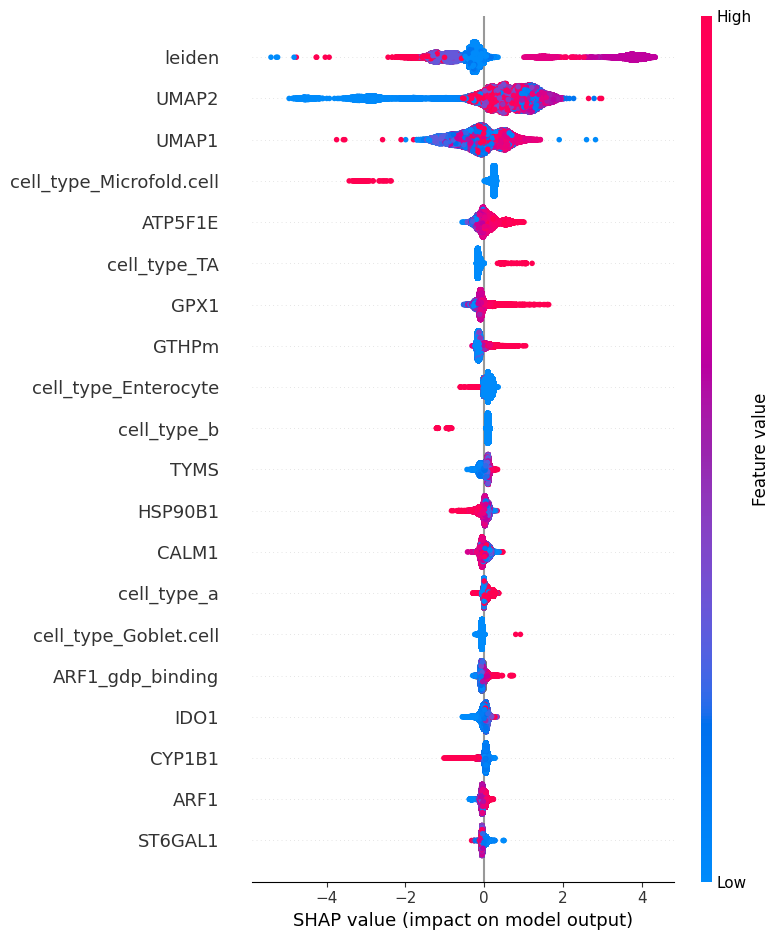

In [45]:
# Treated Class
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

In [ ]:
# Plot SHAP for Class 1 of Random Forest
sv_class1 = shap_values[:, :, 1]
shap.summary_plot(sv_class1, features=X_test_scaled, feature_names=feature_names)

In [ ]:
# Plot both of them
fig, axes = plt.subplots(1, shap_values.shape[2], figsize=(12, 6))

for c in range(shap_values.shape[2]):
    shap.summary_plot(
        shap_values[:, :, c], 
        features=X_test_scaled, 
        feature_names=feature_names, 
        show=False,  
        plot_size=None
    )
    plt.sca(axes[c])
    plt.title(f"Class {c}")

plt.tight_layout()
plt.show()

In [ ]:
# shap diff plot
shap_diff = shap_values[:, :, 1] - shap_values[:, :, 0]
shap.summary_plot(
    shap_diff, 
    features=X_test_scaled, 
    feature_names=feature_names
)

In [ ]:
# Feature importance via mean(|SHAP|)
mean_abs_shap = np.abs(shap_values[:,:,1]).mean(axis=0)
fi = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False)
print("\nTop features by mean(|SHAP|):\n", fi.head(10))

In [ ]:
n_classes = shap_values.shape[2]

for c in range(n_classes):
    mean_abs_shap = np.abs(shap_values[:, :, c]).mean(axis=0)
    fi = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(8, 6))
    fi.head(10).plot(kind='barh')
    plt.xlabel("Mean(|SHAP value|)")
    plt.ylabel("Features")
    # plt.title(f"Top 10 Features by SHAP (Class {c})")
    plt.title(f"Top 10 Features by SHAP (Treated Class)")
    plt.gca().invert_yaxis()
    plt.show()

# Modern Pipeline

### Preprocessing

In [ ]:
# define numerical and categorical feature title
# num_features = [col for col in X.columns if col.startswith("M")]
num_features = X.columns
# cat_features = ["Subject_ID"]

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        # ("cat", categorical_transformer, cat_features)
    ])

### Define Classifier Pipeline with Preprocessor

In [ ]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300, random_state=42, max_depth=8, min_samples_split=20, min_samples_leaf=10))
    # ("classifier", LogisticRegression(max_iter=1000))
])

In [ ]:
clf.fit(X_train, y_train)

### Processed X data

In [ ]:
Xt = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
# Xt_df = pd.DataFrame(Xt.toarray(), columns=list(feature_names))
Xt_df = pd.DataFrame(Xt, columns=list(feature_names))
Xt_df

In [ ]:
# for col in [c for c in Xt_df.columns if c.startswith("num")]:
#     sns.boxplot(x=y_train, y=col, data=Xt_df)
#     plt.title(f"{col} by Treatment")
#     plt.show()

### Feature Importance

In [ ]:
# Mutual Information (non-linear relationships)
mi = mutual_info_classif(Xt_df, y_train, discrete_features='auto')
mi_series = pd.Series(mi, index=Xt_df.columns).sort_values(ascending=False)
mi_series

In [ ]:
# Feature importance from a model
importances = pd.Series(clf['classifier'].feature_importances_, index=Xt_df.columns).sort_values(ascending=False)
importances

In [ ]:
# Pearson / Point-biserial correlation (continuous features vs binary target)
corr = Xt_df.corrwith(y_train)
corr.sort_values()

### Model Evaluation

In [ ]:
y_pred = clf.predict(X_test)
classification_report(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()